# Bike Sharing

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [100]:
import pandas as pd
import seaborn as sns
import datetime
import statsmodels.api as sm
%matplotlib inline
mpl.rc('figure', figsize=(8, 5))
mpl.rc('figure', dpi=100)

In [101]:
train = pd.read_csv("train.csv")

In [102]:
test = pd.read_csv("test.csv")

In [103]:
train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [104]:
train.shape

(10886, 12)

In [105]:
test.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981


In [106]:
test.shape

(6493, 9)

## casual + registered = count
### 일치하지 않는 행 없음

In [107]:
sum((train["casual"] + train["registered"]) != train["count"])

0

In [108]:
train.datetime = pd.to_datetime(train.datetime)
test.datetime = pd.to_datetime(test.datetime)

In [109]:
train['day'] = train.datetime.apply(lambda x: x.day)
test['day'] = test.datetime.apply(lambda x: x.day)

In [110]:
train['weekday'] = train.datetime.apply(lambda x: x.weekday())
test['weekday'] = test.datetime.apply(lambda x: x.weekday())

In [111]:
train['hour'] = train.datetime.apply(lambda x: x.hour)
test['hour'] = test.datetime.apply(lambda x: x.hour)

In [112]:
train['year'] = train.datetime.apply(lambda x: x.year)
test['year'] = test.datetime.apply(lambda x: x.year)

In [113]:
train['month'] = train.datetime.apply(lambda x: x.month)
test['month'] = test.datetime.apply(lambda x: x.month)

## EDA

In [114]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
day           0
weekday       0
hour          0
year          0
month         0
dtype: int64

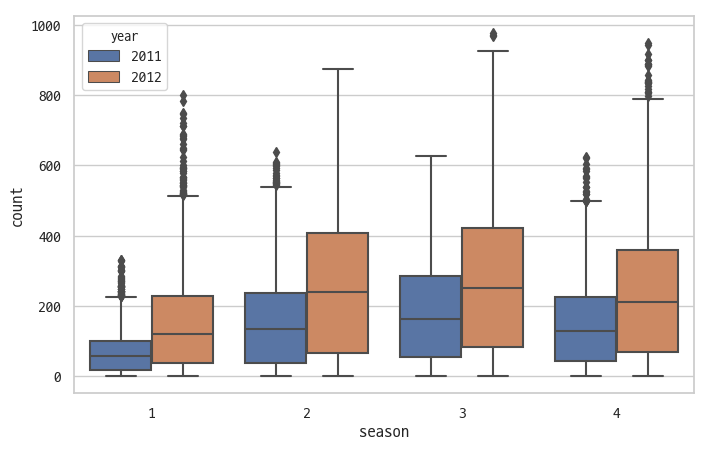

In [115]:
sns.boxplot(x=train.season, y=train["count"], hue=train.year)

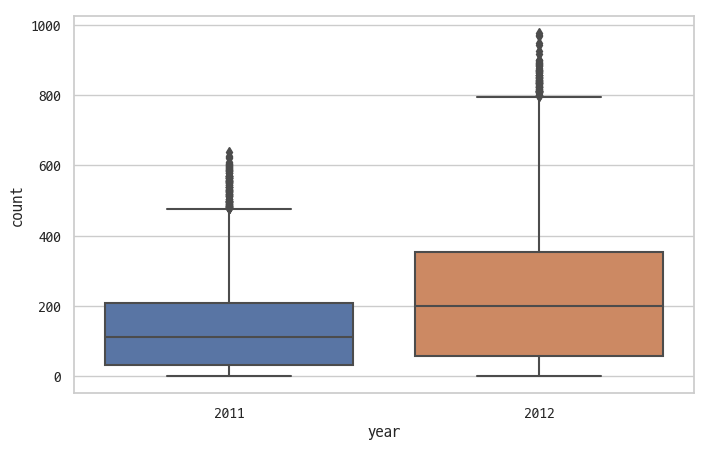

In [116]:
sns.boxplot(x=train.year, y=train["count"])

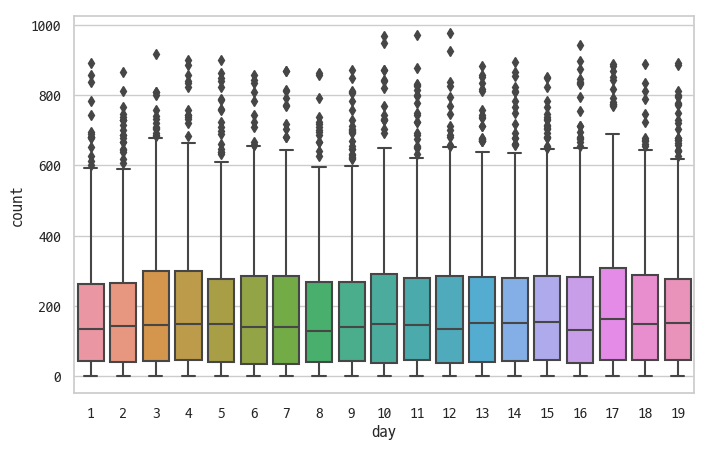

In [117]:
sns.boxplot(x=train.day, y=train["count"])

In [118]:
train[["holiday", "workingday"]].corr()

,holiday,workingday
holiday,1.000000,-0.250491
workingday,-0.250491,1.000000


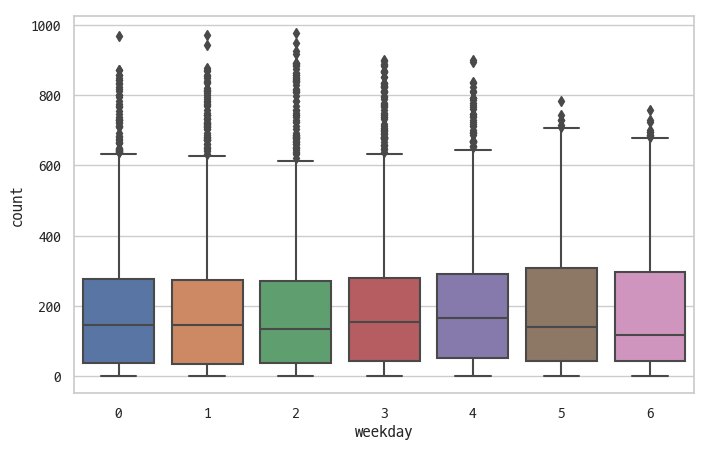

In [119]:
sns.boxplot(x=train.weekday, y=train["count"])

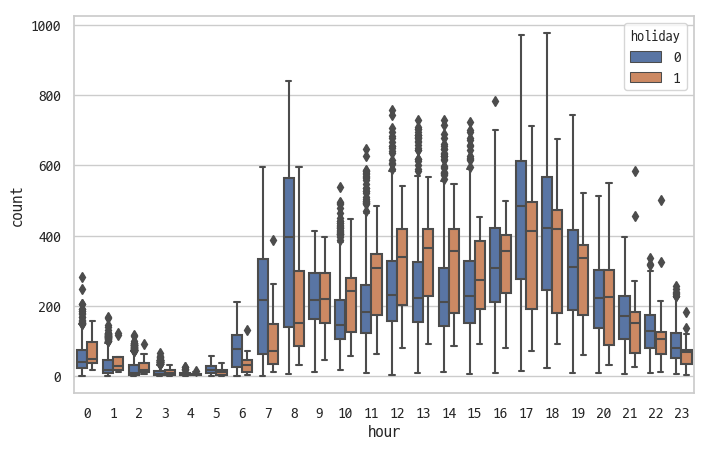

In [120]:
sns.boxplot(x=train.hour, y=train["count"], hue=train.holiday)

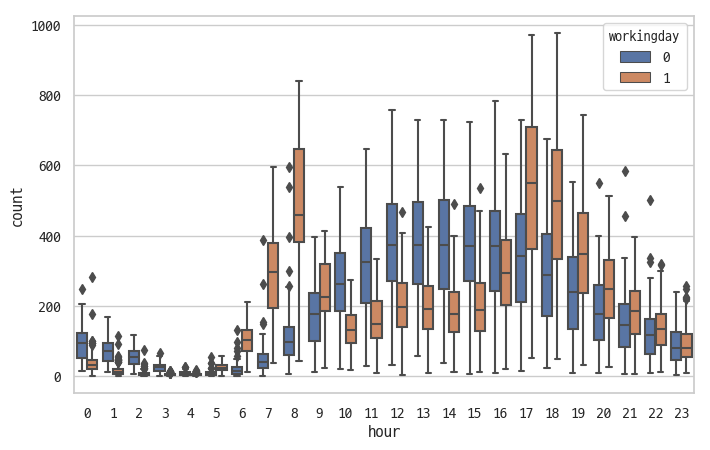

In [121]:
sns.boxplot(x=train.hour, y=train["count"], hue=train.workingday)

### 위의 그래프로 working day일 때는 출퇴근 시간에 사람들의 자전거 이용이 많았고
### 일하지 않는 날에는 오후시간대에 자전거 이용량이 많았다.
### holiday와 그래프의 분포가 거의 비슷하고 holiday의 정보가 workingday에 포함되므로
### holiday 변수를 모델에서 빼줄 것이다.

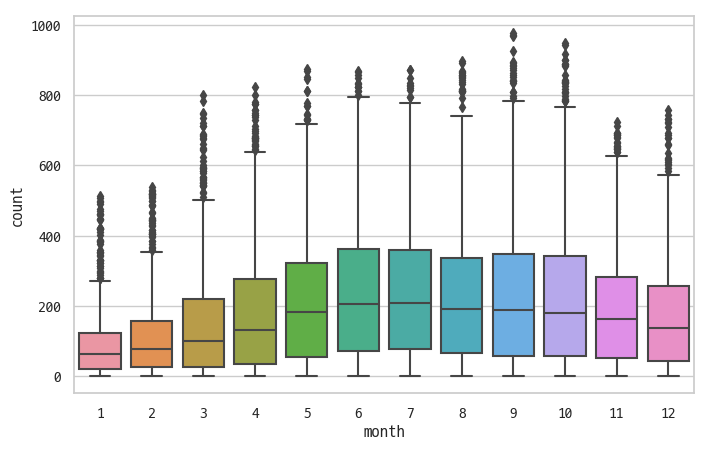

In [122]:
sns.boxplot(x=train.month, y=train["count"])

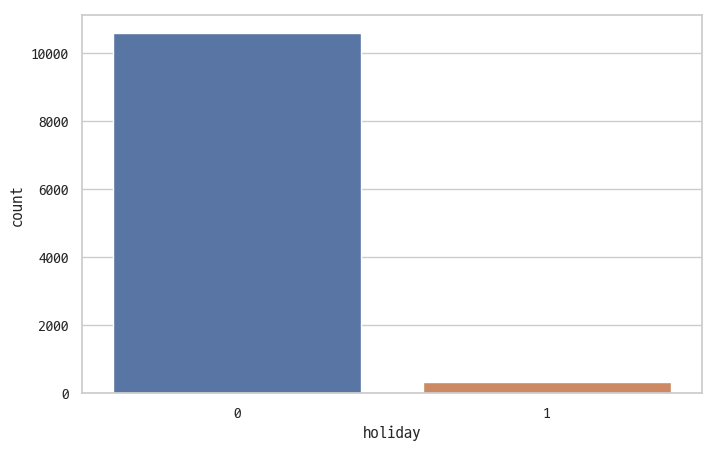

In [123]:
sns.countplot(train.holiday)

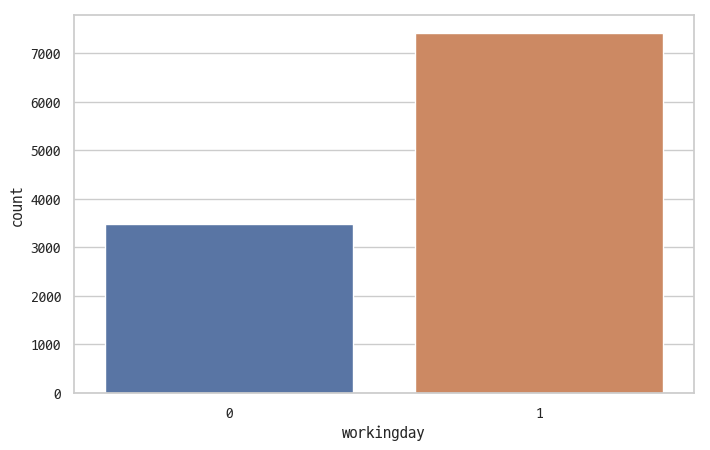

In [124]:
sns.countplot(train.workingday)

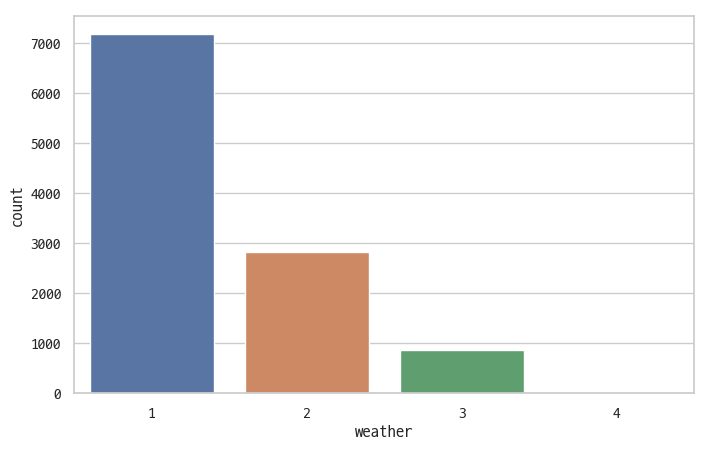

In [125]:
sns.countplot(train.weather)

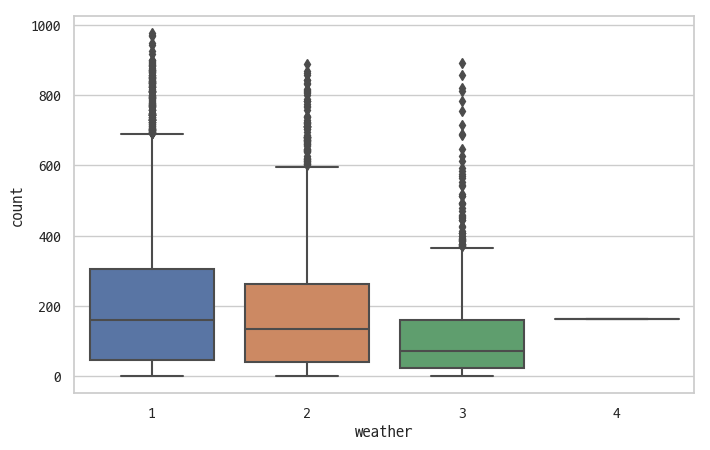

In [126]:
sns.boxplot(x=train.weather, y=train['count'])

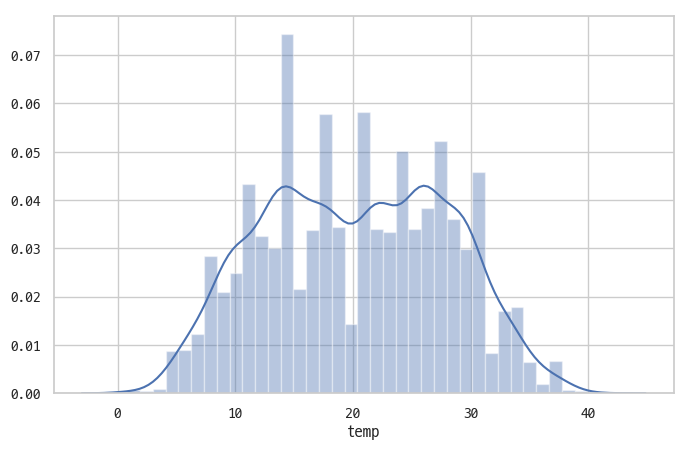

In [127]:
sns.distplot(train.temp)

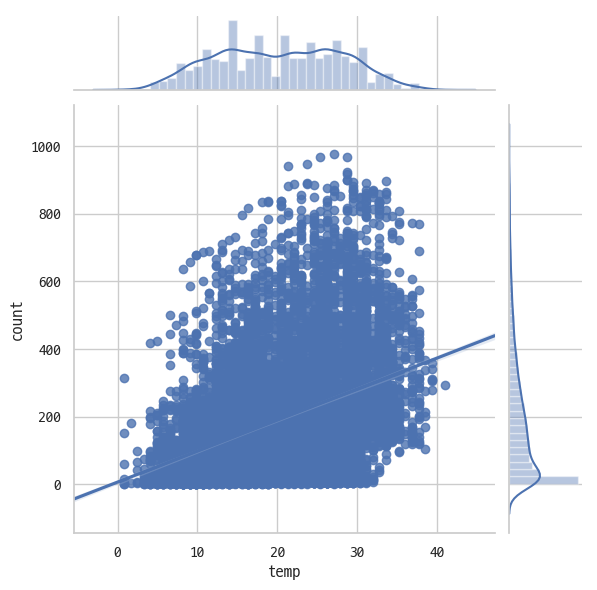

In [128]:
sns.jointplot(x=train.temp, y=train['count'], kind="reg")

In [129]:
train[["temp", "count"]].corr()

,temp,count
temp,1.000000,0.394454
count,0.394454,1.000000


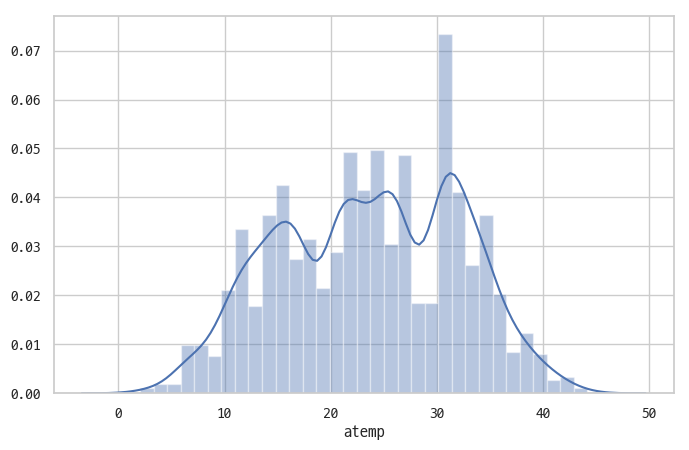

In [130]:
sns.distplot(train.atemp)

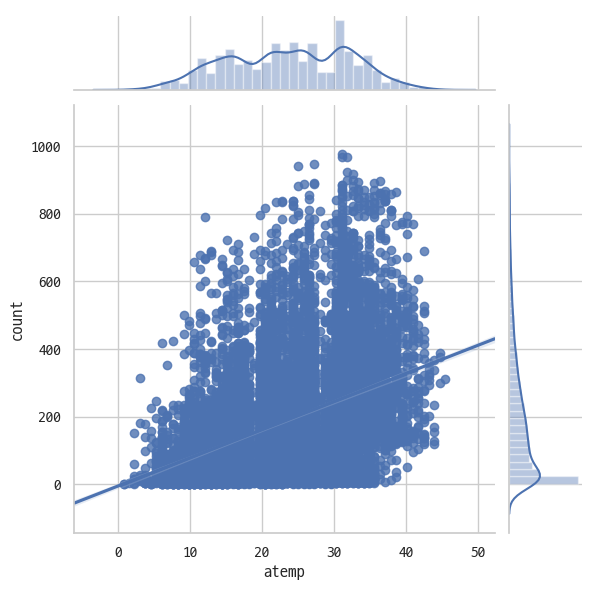

In [131]:
sns.jointplot(x=train.atemp, y=train['count'], kind="reg")

In [132]:
train[["atemp", "count"]].corr()

,atemp,count
atemp,1.000000,0.389784
count,0.389784,1.000000


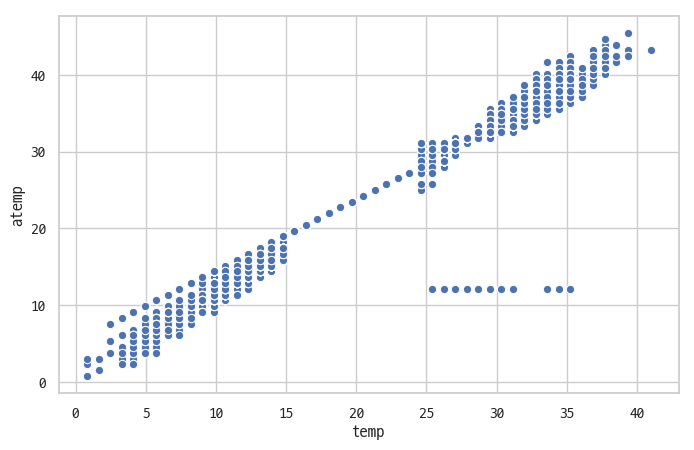

In [133]:
sns.scatterplot(train.temp, train.atemp)

temp가 높은데 atemp 가 12.12로 고정되어 있는 것들이 있음

체감온도를 다시 계산하여 넣어준다.

### 체감온도 
* 현재 사용하고 있는 체감온도 산출식은 2001년 8월 캐나다 토론토에서 열린 Joint Action Group for Temperature Indices (JAG/TI) 회의에서 발표된 것으로 미국과 캐나다 등 북아메리카 국가들을 중심으로 최근에 가장 널리 사용되고 있음

T: 기온(celcius)

V: 풍속(km/h)
$$
\text{feeltemp} = 13.12 + 0.6215T - 11.37V^{0.16} + 0.3965V^{0.16}T
$$


$$
V = \left( \dfrac{\text{feeltemp}-13.12-0.6215T}{-11.37+0.3965T} \right) ^{\frac{100}{16}}
$$

In [134]:
train[train.atemp == train.temp]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,weekday,hour,year,month


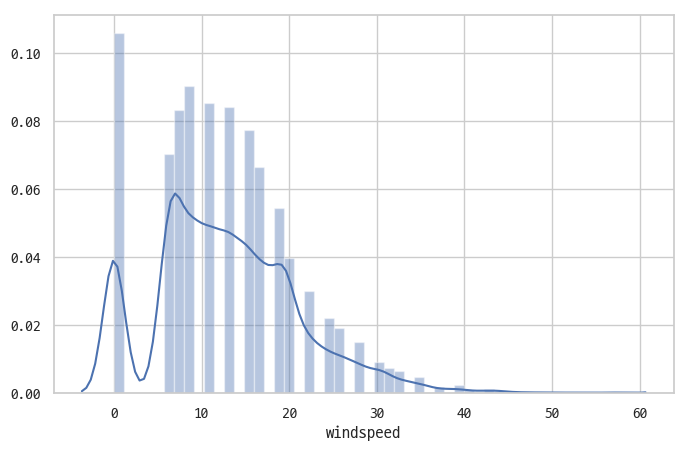

In [135]:
sns.distplot(train.windspeed)

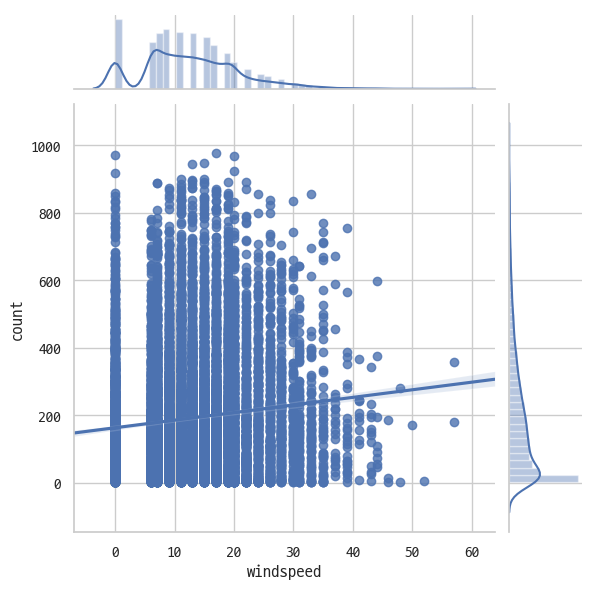

In [136]:
sns.jointplot(x=train.windspeed, y=train['count'], kind='reg')

In [137]:
len(train[train.atemp == 12.12])

195

In [139]:
train[train.atemp == 12.12]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,weekday,hour,year,month
59,2011-01-03 14:00:00,1,0,1,1,10.66,12.12,30,19.0012,11,66,77,3,0,14,2011,1
60,2011-01-03 15:00:00,1,0,1,1,10.66,12.12,30,16.9979,14,58,72,3,0,15,2011,1
61,2011-01-03 16:00:00,1,0,1,1,10.66,12.12,30,16.9979,9,67,76,3,0,16,2011,1
109,2011-01-05 18:00:00,1,0,1,1,9.84,12.12,38,8.9981,3,166,169,5,2,18,2011,1
115,2011-01-06 00:00:00,1,0,1,1,7.38,12.12,55,0.0000,0,11,11,6,3,0,2011,1
123,2011-01-06 09:00:00,1,0,1,2,7.38,12.12,51,0.0000,6,116,122,6,3,9,2011,1
163,2011-01-08 02:00:00,1,0,0,2,7.38,12.12,55,0.0000,3,13,16,8,5,2,2011,1
315,2011-01-14 15:00:00,1,0,1,1,9.84,12.12,38,11.0014,9,59,68,14,4,15,2011,1
316,2011-01-14 16:00:00,1,0,1,1,9.02,12.12,41,7.0015,3,87,90,14,4,16,2011,1
320,2011-01-14 20:00:00,1,0,1,1,7.38,12.12,59,0.0000,0,68,68,14,4,20,2011,1


In [138]:
len(train[(train.temp > 25) & (train.atemp == 12.12)])

24

In [40]:
feeltemp = 13.12 + 0.6215*train.temp - 11.37*(train.windspeed**0.16) + 0.3965*(train.windspeed**0.16)*train.temp

In [41]:
train.atemp[train.atemp == 12.12] = feeltemp[train.atemp == 12.12]

In [42]:
7.38 * 0.6215

4.586670000000001

In [43]:
train[(train.atemp == 12.12) & (train.temp > 25) & (train.windspeed == 0)]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,weekday,hour,year,month


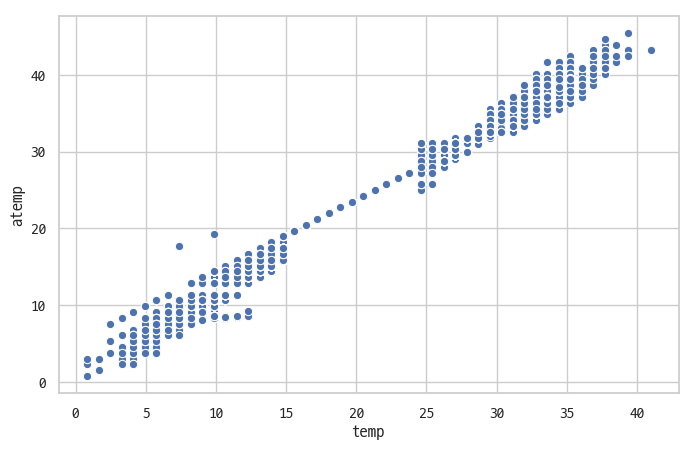

In [44]:
sns.scatterplot(train.temp, train.atemp)

## 체감온도와 기온의 상관관계가 거의 1이므로 체감온도를 사용

In [45]:
train[["temp", "atemp"]].corr()

,temp,atemp
temp,1.00000,0.99018
atemp,0.99018,1.00000


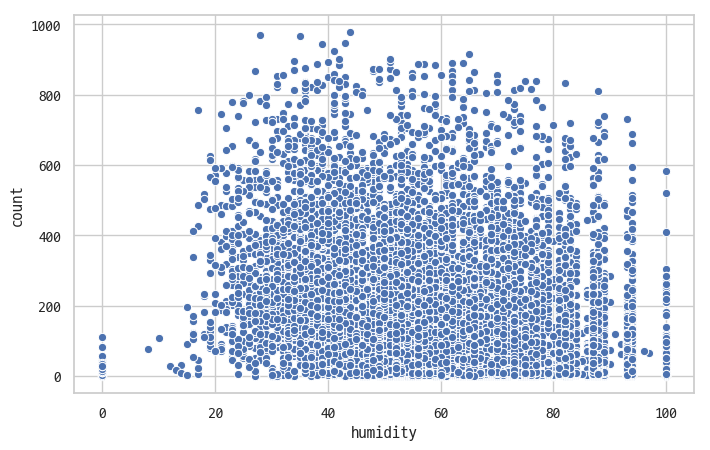

In [46]:
sns.scatterplot(train.humidity, train["count"])

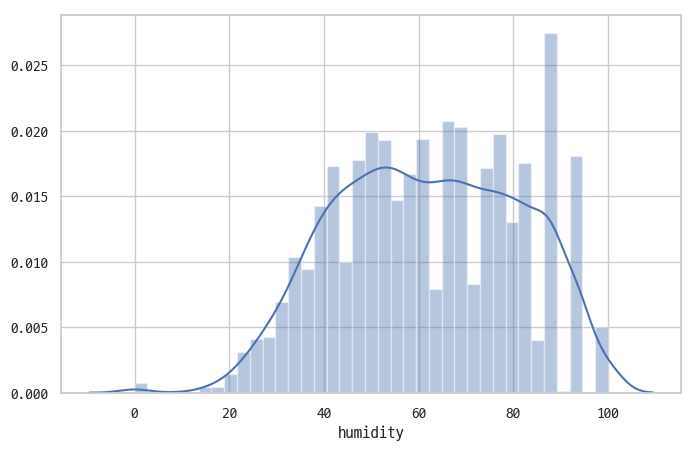

In [47]:
sns.distplot(train.humidity)

- 2011년 3월 10일에 습도의 양은 0이다. 기록 누락으로 보인다.
- weahter가 3인 각 시간의 평균을 가져와 넣는다.

In [48]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,weekday,hour,year,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,5,0,2011,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1,2011,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,5,2,2011,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,5,3,2011,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,5,4,2011,1


In [49]:
train[(train['day'] == 10) & (train.month == 3) & (train.year == 2011)]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,weekday,hour,year,month
1091,2011-03-10 00:00:00,1,0,1,3,13.94,15.910,0,16.9979,3,0,3,10,3,0,2011,3
1092,2011-03-10 01:00:00,1,0,1,3,13.94,15.910,0,16.9979,0,2,2,10,3,1,2011,3
1093,2011-03-10 02:00:00,1,0,1,3,13.94,15.910,0,16.9979,0,1,1,10,3,2,2011,3
1094,2011-03-10 05:00:00,1,0,1,3,14.76,17.425,0,12.9980,1,2,3,10,3,5,2011,3
1095,2011-03-10 06:00:00,1,0,1,3,14.76,16.665,0,22.0028,0,12,12,10,3,6,2011,3
1096,2011-03-10 07:00:00,1,0,1,3,15.58,19.695,0,15.0013,1,36,37,10,3,7,2011,3
1097,2011-03-10 08:00:00,1,0,1,3,15.58,19.695,0,19.0012,1,43,44,10,3,8,2011,3
1098,2011-03-10 09:00:00,1,0,1,3,16.40,20.455,0,15.0013,1,23,24,10,3,9,2011,3
1099,2011-03-10 10:00:00,1,0,1,3,16.40,20.455,0,11.0014,0,17,17,10,3,10,2011,3
1100,2011-03-10 11:00:00,1,0,1,3,16.40,20.455,0,16.9979,6,5,11,10,3,11,2011,3


In [50]:
len(train[train.humidity == 0])

22

In [51]:
mean_humidity = train[(train.weather == 3)].pivot_table('humidity', index='hour', columns='weather', aggfunc="mean")

In [52]:
mean_humidity

weather,3
hour,
0,82.821429
1,82.473684
2,84.156250
3,86.733333
4,86.083333
5,84.121212
6,83.642857
7,84.697674
8,83.378378


In [53]:
mean_humidity_r = mean_humidity.drop(labels=[3,4])

In [54]:
mean_humidity_r

weather,3
hour,
0,82.821429
1,82.473684
2,84.156250
5,84.121212
6,83.642857
7,84.697674
8,83.378378
9,81.875000
10,80.718750


In [55]:
train.humidity[train.humidity == 0] = mean_humidity_r.values

- humidity가 0인 행이 없다.

In [56]:
train[train.humidity == 0]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,weekday,hour,year,month


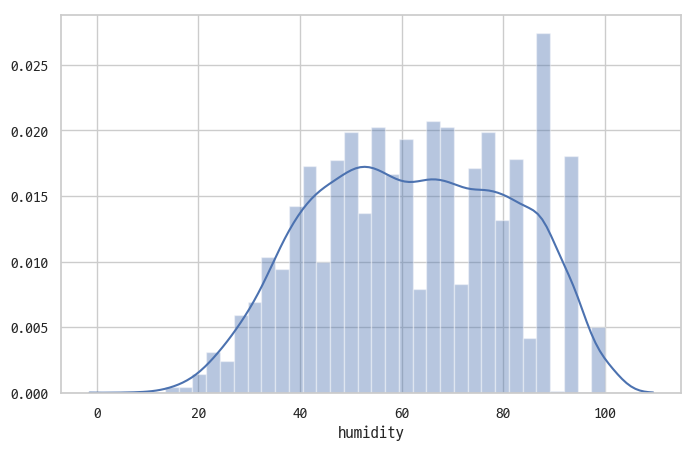

In [57]:
sns.distplot(train.humidity)

## windspeed가 0인 것이 많다.
## 체감온도 구하는 공식을 보니 windspeed가 들어있다.
## windspeed를 제외

In [58]:
train.iloc[10]

datetime      2011-01-01 10:00:00
season                          1
holiday                         0
workingday                      0
weather                         1
temp                        15.58
atemp                      19.695
humidity                       76
windspeed                 16.9979
casual                         12
registered                     24
count                          36
day                             1
weekday                         5
hour                           10
year                         2011
month                           1
Name: 10, dtype: object

In [59]:
train[["windspeed", "count"]].corr()

,windspeed,count
windspeed,1.000000,0.101369
count,0.101369,1.000000


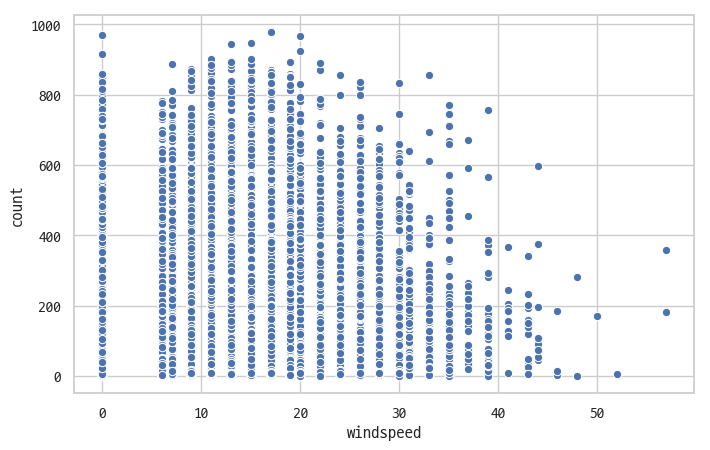

In [60]:
sns.scatterplot(train.windspeed, train["count"])

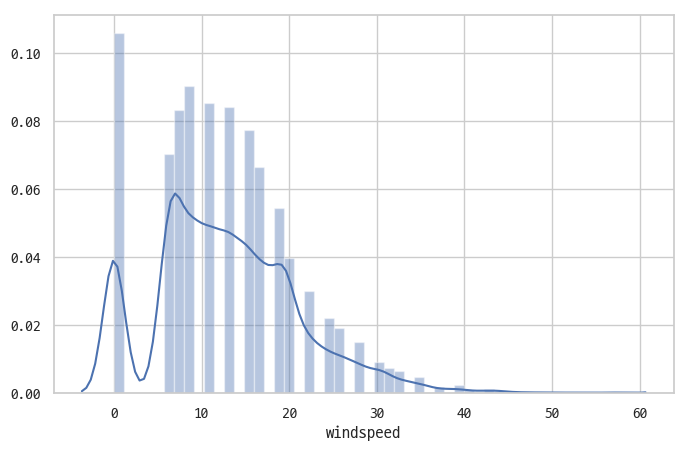

In [61]:
sns.distplot(train.windspeed)

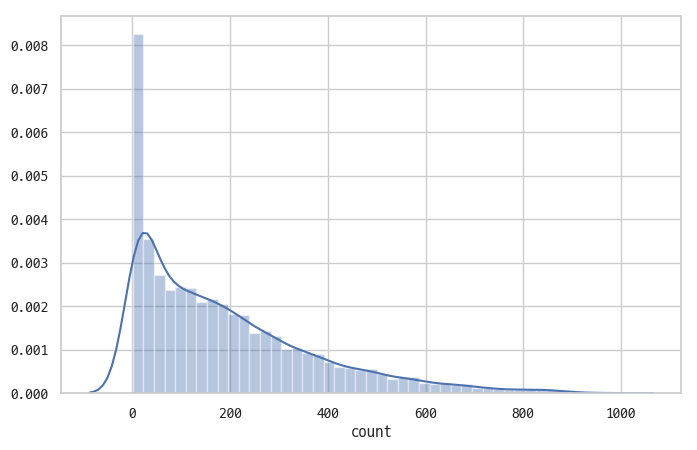

In [66]:
sns.distplot(train['count'])

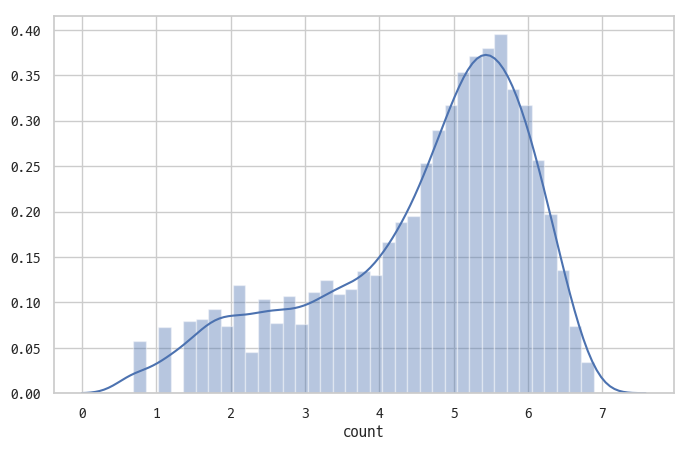

In [67]:
sns.distplot(np.log1p(train['count']))

In [68]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,weekday,hour,year,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16,1,5,0,2011,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40,1,5,1,2011,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32,1,5,2,2011,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13,1,5,3,2011,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1,1,5,4,2011,1


In [69]:
train[train['count'] == 2]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,weekday,hour,year,month
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635000,80.0,0.0000,2,0,2,1,5,6,2011,1
29,2011-01-02 06:00:00,1,0,0,3,17.22,21.210000,77.0,19.9995,0,2,2,2,6,6,2011,1
48,2011-01-03 01:00:00,1,0,1,1,8.20,8.335000,44.0,27.9993,0,2,2,3,0,1,2011,1
70,2011-01-04 01:00:00,1,0,1,1,6.56,9.090000,59.0,7.0015,0,2,2,4,1,1,2011,1
72,2011-01-04 04:00:00,1,0,1,1,5.74,9.090000,63.0,6.0032,0,2,2,4,1,4,2011,1
94,2011-01-05 02:00:00,1,0,1,1,6.56,9.850000,74.0,6.0032,0,2,2,5,2,2,2011,1
95,2011-01-05 04:00:00,1,0,1,1,9.84,11.365000,48.0,15.0013,0,2,2,5,2,4,2011,1
117,2011-01-06 02:00:00,1,0,1,1,6.56,11.365000,64.0,0.0000,0,2,2,6,3,2,2011,1
167,2011-01-08 06:00:00,1,0,0,2,6.56,8.335000,74.0,11.0014,0,2,2,8,5,6,2011,1
278,2011-01-13 01:00:00,1,0,1,1,5.74,6.060000,50.0,19.0012,0,2,2,13,3,1,2011,1


In [70]:
model = sm.OLS.from_formula('np.log1p(count) ~ C(season) + C(workingday) + scale(atemp) + scale(humidity) + C(weekday) + C(weather) + C(hour) + C(month) + C(year) + 0', data=train)

In [71]:
result = model.fit()

In [72]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(count)   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1163.
Date:                Sat, 15 Dec 2018   Prob (F-statistic):               0.00
Time:                        23:34:53   Log-Likelihood:                -9467.9
No. Observations:               10886   AIC:                         1.903e+04
Df Residuals:                   10838   BIC:                         1.938e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(season)[1]           3.0575      0

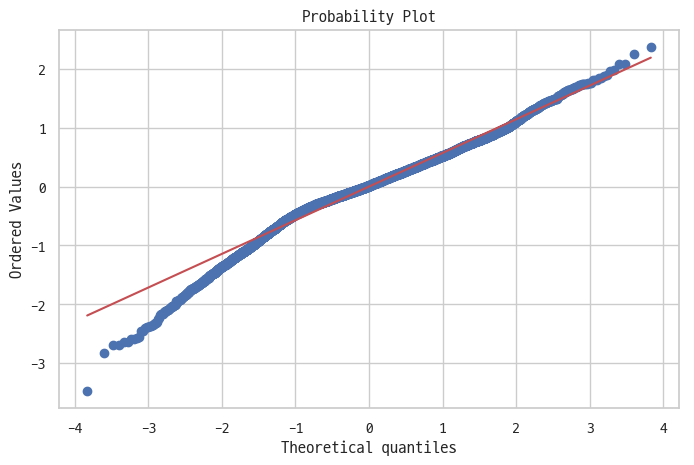

In [73]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [74]:
test2 = sm.stats.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test2):
    print("%-12s: %6.3f" % xi)

Chi^2       : 769.045
P-value     :  0.000


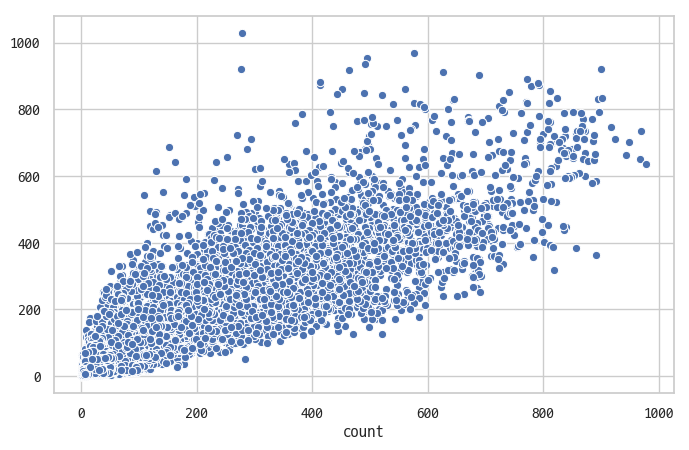

In [75]:
sns.scatterplot(train["count"], np.exp(result.predict(train.drop(columns="count")))-1)

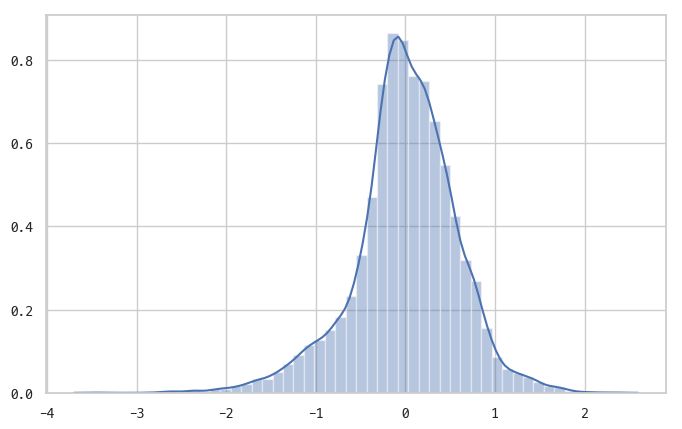

In [76]:
sns.distplot(result.resid)

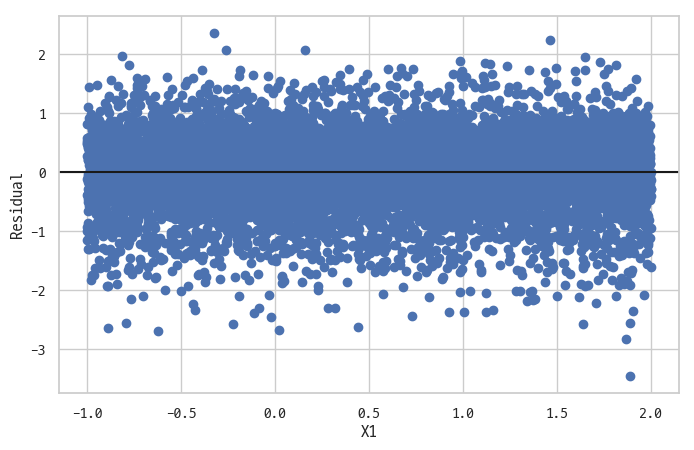

In [77]:
plt.plot(np.random.rand(len(train)) * 3 - 1, result.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

## 아웃라이어 & 레버리지

In [78]:
from statsmodels.graphics import utils

influence = result.get_influence()
cooks_d2, pvals = influence.cooks_distance

hat = influence.hat_matrix_diag

fox_cr = hat.sum() / len(train)
idx = np.where(cooks_d2 > fox_cr)[0]

In [79]:
idx

array([5631], dtype=int64)

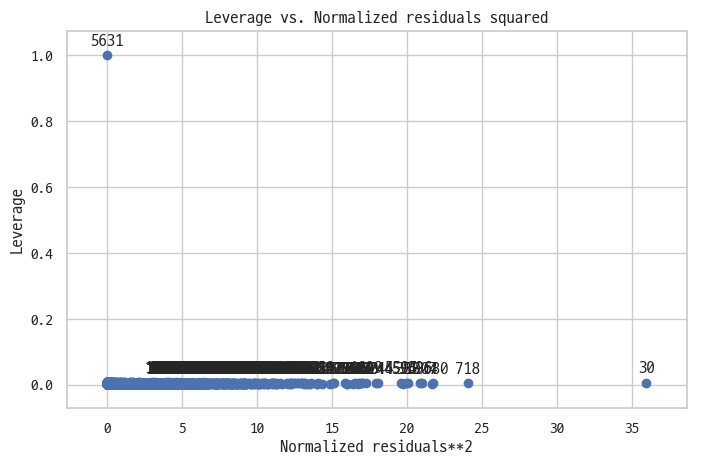

In [80]:
sm.graphics.plot_leverage_resid2(result)
plt.show()

- 5631을 빼야 하지만, test데이터에 weather 4가 들어 있어 뺄수가 없음, 
- 교차검증은 5631을 빼고 시행

## 교차검증

In [81]:
from sklearn.model_selection import KFold
kfold_train = train.drop(5631)
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(kfold_train)):
    df_train = kfold_train.iloc[idx_train]
    df_test = kfold_train.iloc[idx_test]
    
    model = sm.OLS.from_formula('np.log1p(count) ~ C(workingday)+ C(weather) + scale(atemp) + scale(humidity) + C(weekday) + C(hour) + C(month) + C(year) + 0', data=df_train)
    result2 = model.fit()
    
    pred = np.exp(result.predict(df_test))-1
    rss = ((df_test["count"] - pred) ** 2).sum()
    tss = ((df_test["count"] - df_test["count"].mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result2.rsquared, rsquared))

학습 R2 = 0.83297487, 검증 R2 = 0.72811046
학습 R2 = 0.83712551, 검증 R2 = 0.70259840
학습 R2 = 0.83583535, 검증 R2 = 0.72500841
학습 R2 = 0.83770288, 검증 R2 = 0.71573319
학습 R2 = 0.82986321, 검증 R2 = 0.74161630


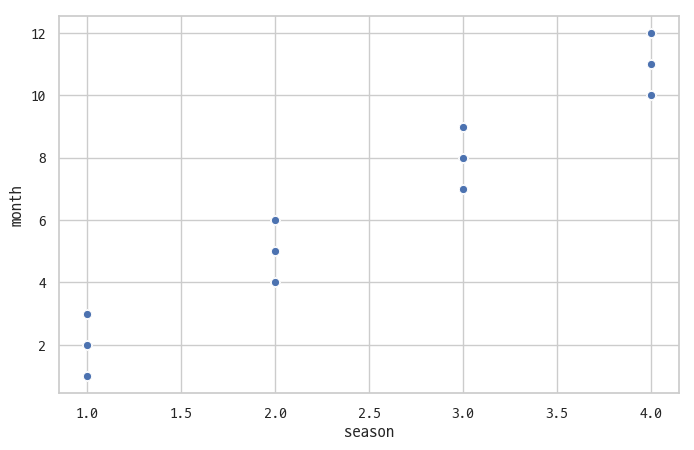

In [82]:
sns.scatterplot(train.season, train.month)

In [83]:
train[["season", "month"]].corr()

,season,month
season,1.000000,0.971524
month,0.971524,1.000000


In [84]:
train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,weekday,hour,year,month
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.267199,0.180849,-0.147121,0.096758,0.164011,0.163439,0.001729,-0.010553,-0.006546,-0.004797,0.971524
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.006379,0.000475,0.008409,0.043799,-0.020956,-0.005393,-0.015877,-0.191832,-0.000354,0.012021,0.001731
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.029865,-0.005105,0.013373,-0.319111,0.119460,0.011594,0.009829,-0.704267,0.002780,-0.002482,-0.003394
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.056078,0.430338,0.007261,-0.135918,-0.109340,-0.128655,-0.007890,-0.047692,-0.022740,-0.012548,0.012144
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.990180,-0.070337,-0.017852,0.467097,0.318571,0.394454,0.015551,-0.038466,0.145430,0.061226,0.257589
atemp,0.267199,-0.006379,0.029865,-0.056078,0.990180,1.000000,-0.051005,-0.056370,0.464997,0.318133,0.393509,0.020150,-0.038722,0.141182,0.061861,0.266347
humidity,0.180849,0.000475,-0.005105,0.430338,-0.070337,-0.051005,1.000000,-0.316718,-0.357363,-0.275377,-0.328173,-0.011432,-0.026821,-0.279932,-0.087981,0.197722
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.056370,-0.316718,1.000000,0.092276,0.091052,0.101369,0.036157,-0.024804,0.146631,-0.015221,-0.150192
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.464997,-0.357363,0.092276,1.000000,0.497250,0.690414,0.014109,0.246959,0.302045,0.145241,0.092722
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.318133,-0.275377,0.091052,0.497250,1.000000,0.970948,0.019111,-0.084427,0.380540,0.264265,0.169451


In [91]:
model = sm.OLS.from_formula('np.log1p(count) ~ C(workingday) + scale(atemp) + C(month) + scale(humidity) + C(weather) + C(weekday) + C(hour) + C(year) + 0', data=train)

In [92]:
result = model.fit()

In [87]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(count)   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1163.
Date:                Sat, 15 Dec 2018   Prob (F-statistic):               0.00
Time:                        23:35:01   Log-Likelihood:                -9467.9
No. Observations:               10886   AIC:                         1.903e+04
Df Residuals:                   10838   BIC:                         1.938e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(workingday)[0]     3.0575      0.050  

In [98]:
from sklearn.model_selection import KFold
kfold_train = train.drop(5631)
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(kfold_train)):
    df_train = kfold_train.iloc[idx_train]
    df_test = kfold_train.iloc[idx_test]
    
    model = sm.OLS.from_formula('np.log1p(count) ~ C(workingday)+ C(weather) + scale(atemp) + scale(humidity) + C(weekday) + C(hour) + C(month) + C(year) + 0', data=df_train)
    result2 = model.fit()
    
    pred = np.exp(result.predict(df_test))-1
    rss = ((df_test["count"] - pred) ** 2).sum()
    tss = ((df_test["count"] - df_test["count"].mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result2.rsquared, rsquared))

학습 R2 = 0.83297487, 검증 R2 = 0.72932539
학습 R2 = 0.83712551, 검증 R2 = 0.70447601
학습 R2 = 0.83583535, 검증 R2 = 0.72939303
학습 R2 = 0.83770288, 검증 R2 = 0.71562198
학습 R2 = 0.82986321, 검증 R2 = 0.74486317


In [90]:
train[train.weather == 4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day,weekday,hour,year,month
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86.0,6.0032,6,158,164,9,0,18,2012,1


In [93]:
test_predict = result.predict(test)

In [94]:
test_predict = np.exp(test_predict) - 1

In [95]:
submission = pd.concat([test.datetime, test_predict], axis=1)

In [96]:
submission.columns = ["datetime", "count"]

In [97]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,15.344808
1,2011-01-20 01:00:00,8.471827
2,2011-01-20 02:00:00,4.777361
3,2011-01-20 03:00:00,2.459730
4,2011-01-20 04:00:00,1.648671


In [ ]:
submission.to_csv("submission.csv", index=False)

![image](https://user-images.githubusercontent.com/17154958/49863970-c8821680-fe44-11e8-81ef-fb73270ca907.png)
